In [111]:
import numpy as np
import pandas as pd
import importlib as imp
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib import rcParams

import titanic_util as tu
tu = imp.reload(tu)

In [112]:
%matplotlib inline
rcParams['figure.figsize'] = 5,4

In [113]:
titanic_data = tu.load(opt='train')

attaching_keys=['Sex','Age','Fare','Pclass','SibSp','Parch',np.array(['Parch','SibSp'])]

new_data, data_targets = tu.mung(titanic_data, attaching_keys, base_truth='Survived')

display(titanic_data.head())
display(new_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Sex,Age,Fare,1,2,3,SibSp,Parch,FamSize
0,-0.737695,-0.592481,-0.502445,-0.565685,-0.510152,0.902587,0.432793,-0.473674,0.059160
1,1.355574,0.638789,0.786845,1.767767,-0.510152,-1.107926,0.432793,-0.473674,0.059160
2,1.355574,-0.284663,-0.488854,-0.565685,-0.510152,0.902587,-0.474545,-0.473674,-0.560975
3,1.355574,0.407926,0.420730,1.767767,-0.510152,-1.107926,0.432793,-0.473674,0.059160
4,-0.737695,0.407926,-0.486337,-0.565685,-0.510152,0.902587,-0.474545,-0.473674,-0.560975


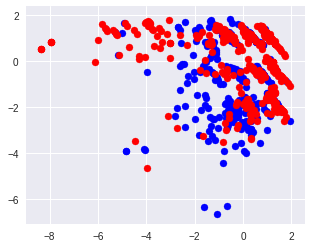

In [114]:
#TODO plot in 3-D as well

pca_vis = tu.PCA(task_type='reduce_dim', pc_count=2)
reduced_data = pca_vis.fit(new_data)

reduced_data = DataFrame(reduced_data); reduced_data.index = new_data.index

who_lives = reduced_data.loc[data_targets==1]
who_dies = reduced_data.loc[data_targets==0]

plt.scatter(who_lives.iloc[:,0], who_lives.iloc[:,1], color='b')
plt.scatter(who_dies.iloc[:,0], who_dies.iloc[:,1], color='r')
plt.show()

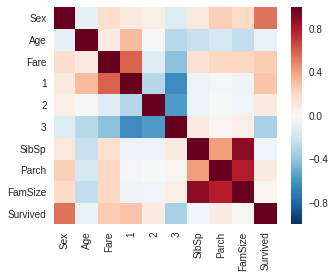

In [115]:
corr = new_data.join(titanic_data['Survived']).corr()

display(sb.heatmap(corr))

In [116]:
log_reg = tu.LogisticRegressor(max_it=5000, lambd=0.3, alpha=0.01, metric='f1_score')

log_reg.fit(new_data, data_targets, portion_train=0.7, return_differences=True)

print('Training {} was {}'.format(log_reg.metric, 100 - log_reg.train_error))
print('Cross-validation {} was {}'.format(log_reg.metric, 100 - log_reg.cv_error))
print('Optimal weights are: \n{}'.format(log_reg.weights))

,mean_overall,mean_misclass,std_overall,std_misclass
Sex,0.025021,0.083195,1.008199,1.025356
Age,-0.028223,-0.094643,1.010851,1.034838
Fare,0.000170,-0.014077,1.033063,0.839411
1,-0.007605,0.120624,0.996190,1.066718
2,-0.026391,-0.235668,0.981112,0.778907
3,0.028030,0.087870,0.997525,0.990275
SibSp,0.011893,0.029532,1.024457,0.918545
Parch,0.012487,0.118582,1.042164,1.200494
FamSize,0.014367,0.079426,1.029353,1.022006


,mean_overall,mean_misclass,std_overall,std_misclass
Sex,-0.058164,-0.054179,0.981976,0.991798
Age,0.065608,-0.096537,0.974925,0.906103
Fare,-0.000394,0.057092,0.922442,0.923826
1,0.017678,0.386744,1.012305,1.158762
2,0.061348,-0.207659,1.043676,0.818183
3,-0.065160,-0.164216,1.006436,1.013769
SibSp,-0.027647,-0.030134,0.943955,0.670921
Parch,-0.029028,-0.043017,0.897602,0.823037
FamSize,-0.033398,-0.042087,0.931192,0.752586


Training f1_score was 75.4414125200642
Cross-validation f1_score was 81.71641791044776
Optimal weights are: 
0    1.220627
1   -0.422160
2    0.177437
3    0.466767
4    0.091806
5   -0.476885
6   -0.224384
7   -0.039758
8   -0.173221
dtype: float64


In [117]:
testing_data = tu.load('test')

testing_data = tu.mung(testing_data, attaching_keys)

pred = log_reg.predict(testing_data)

display(pred)

0      0.0
1      1.0
2      0.0
3      0.0
4      1.0
5      0.0
6      1.0
7      0.0
8      1.0
9      0.0
10     0.0
11     0.0
12     1.0
13     0.0
14     1.0
15     1.0
16     0.0
17     0.0
18     1.0
19     1.0
20     0.0
21     0.0
22     1.0
23     1.0
24     1.0
25     0.0
26     1.0
27     0.0
28     1.0
29     0.0
      ... 
388    0.0
389    0.0
390    1.0
391    1.0
392    0.0
393    0.0
394    0.0
395    1.0
396    0.0
397    1.0
398    0.0
399    0.0
400    1.0
401    0.0
402    1.0
403    1.0
404    0.0
405    0.0
406    0.0
407    0.0
408    1.0
409    1.0
410    1.0
411    1.0
412    1.0
413    0.0
414    1.0
415    0.0
416    0.0
417    0.0
Length: 418, dtype: float64